# The challenge is to use the provided data set and write code to:

- Specify the machine learning model.
- Add the text data to the vector database.
- Search the database using both text and image queries.

This process helps in creating a smart search system that can understand and match both text and images effectively.

In [1]:
import pickle
import os
import json
import weaviate
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

d:\Vector Databases\vector-databases-certification\env\Lib\site-packages\google\protobuf\runtime_version.py:112: UserWarning: Protobuf gencode version 5.27.2 is older than the runtime version 5.28.0 at grpc_health/v1/health.proto. Please avoid checked-in Protobuf gencode that can be obsolete.
  warnings.warn(


In [2]:
# Connect to the locallay launched instance of Weaviate
client = weaviate.Client("http://localhost:8080")

print(f"Client is ready: {client.is_ready()}")

d:\Vector Databases\vector-databases-certification\env\Lib\site-packages\weaviate\warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(


Client is ready: True


In [3]:
# Check and delete already existed class
current_schema = client.schema.get()['classes']

for schema in current_schema:
    if schema['class'] == 'TextImageSearch':
        client.schema.delete_class(schema['class'])

In [4]:
# create a class object that use multi2vec module  
class_object = {
    "class": "TextImageSearch",
    "moduleConfig": {
        "multi2vec-clip": {"imageFields": ["image"]},
    },
    "vectorizer" : "multi2vec-clip",
    "properties": [
        {
            "name": "text",
            "dataType": ["string"]
        },
        {
            "name": "image",
            "dataType": ["blob"]
        }
    ]
}

client.schema.create_class(class_object)
print("Class created")

Class created


In [6]:
# Add images to our created class
# You can add your own images 
image_folder = r"D:/Vector Databases/vector-databases-certification/03 Machine Learning Vectors/Images"

for imgs in os.listdir(image_folder):
    encoded_image = weaviate.util.image_encoder_b64(f"{image_folder}/{imgs}")
    data_properties = {
        "text": imgs,
        "image": encoded_image
    }
    try:
        client.data_object.create(data_properties, "TextImageSearch")
        print(f"Image {imgs} added")
    except weaviate.exceptions.UnexpectedStatusCodeException as e:
        print(f"Failed to add image {imgs}: {e}")

print("All images processed")

Image Big Sur_ California_LIL_9678.jpg added
Image Bird feeder_LIL_134172.jpg added
Image Blue sky between skyscrapers_LIL_134160.jpg added
Image Cats on a chair_LIL_134151.jpg added
Image Cat_LIL_134138.jpg added
Image Cherry_LIL_134126.jpg added
Image Cityscape_LIL_134155.jpg added
Image Conservatory_LIL_9680.jpg added
Image Deer_LIL_134180.jpg added
Image Dog in motion_LIL_134175.jpg added
Image Feet under a skirt_LIL_134201.jpg added
Image Forest_LIL_134133.jpg added
Image Golden Gate Bridge from Presidio_LIL_9682.jpg added
Image Joshua Tree and California coast_LIL_9662.jpg added
Image Joshua Tree and California coast_LIL_9670.jpg added
Image Kitchen scene_LIL_134191.jpg added
Image Llama_LIL_134178.jpg added
Image Microphone_LIL_134215.jpg added
Image On a grassy hill_LIL_134221.jpg added
Image Onlookers contemplating_LIL_134225.jpg added
Image Ornate furniture_LIL_134195.jpg added
Image Pies and dishes_LIL_134217.jpg added
Image Point Reyes_ California_LIL_9672.jpg added
Image R

In [20]:
# Search images using a text query
query_image = (
    client.query
    .get('TextImageSearch', ['text', "_additional {distance}"])
    .with_near_text({"concepts": "cute cats"})
    .with_limit(2)
    .do()
)

print(json.dumps(query_image, indent=2))

{
  "data": {
    "Get": {
      "TextImageSearch": [
        {
          "_additional": {
            "distance": 0.7432544
          },
          "text": "Cats on a chair_LIL_134151.jpg"
        },
        {
          "_additional": {
            "distance": 0.76307213
          },
          "text": "Cat_LIL_134138.jpg"
        }
      ]
    }
  }
}


In [22]:
# Get the names of the images
for img in query_image['data']['Get']['TextImageSearch']:
    print(f"Image: {img['text']}")

Image: Cats on a chair_LIL_134151.jpg
Image: Cat_LIL_134138.jpg


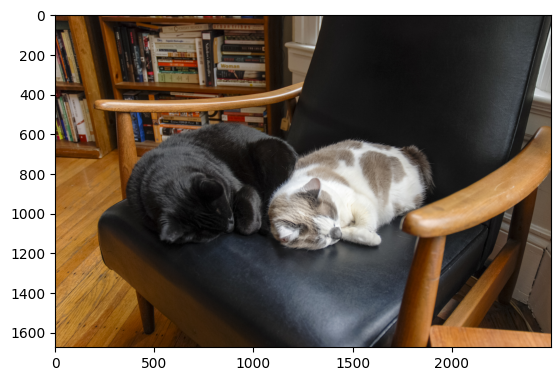

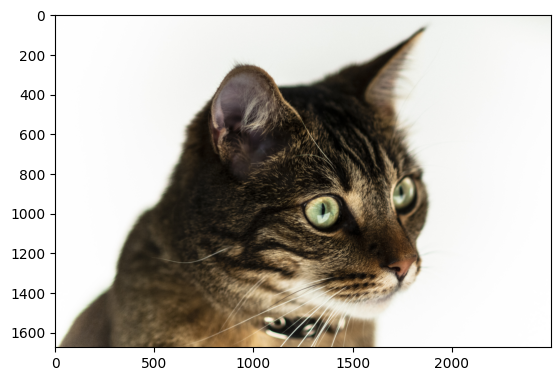

In [23]:
# Display those images from query
for img in query_image['data']['Get']['TextImageSearch']:
    img_name = img['text']
    img_path = f"{image_folder}/{img_name}"
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

In [28]:
# Search the data an image query
# Test Image = Alone in office building _LIL_134159.jpg
query_image = (
    client.query
    .get('TextImageSearch', ['text', "_additional {distance}"])
    .with_near_image({"image": "D:/Vector Databases/vector-databases-certification/03 Machine Learning Vectors/TestImages/Alone in office building _LIL_134159.jpg"})
    .with_limit(5)
    .do()
)

print(json.dumps(query_image, indent=2))

{
  "data": {
    "Get": {
      "TextImageSearch": [
        {
          "_additional": {
            "distance": 0.26516557
          },
          "text": "Blue sky between skyscrapers_LIL_134160.jpg"
        },
        {
          "_additional": {
            "distance": 0.27387208
          },
          "text": "Cityscape_LIL_134155.jpg"
        },
        {
          "_additional": {
            "distance": 0.2782424
          },
          "text": "Spiral staircase_LIL_134156.jpg"
        },
        {
          "_additional": {
            "distance": 0.29633278
          },
          "text": "Reading outside_LIL_134129.jpg"
        },
        {
          "_additional": {
            "distance": 0.3055023
          },
          "text": "Wearing a white dress _LIL_134222.jpg"
        }
      ]
    }
  }
}


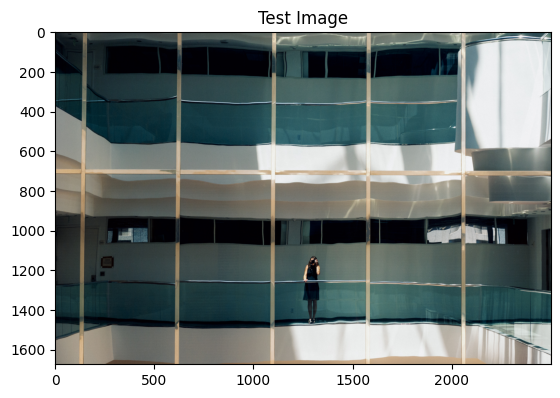

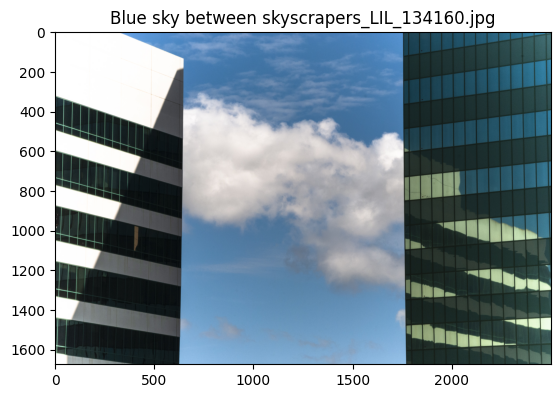

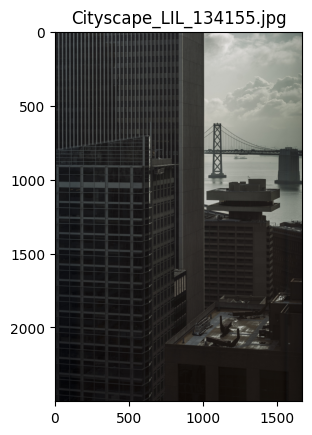

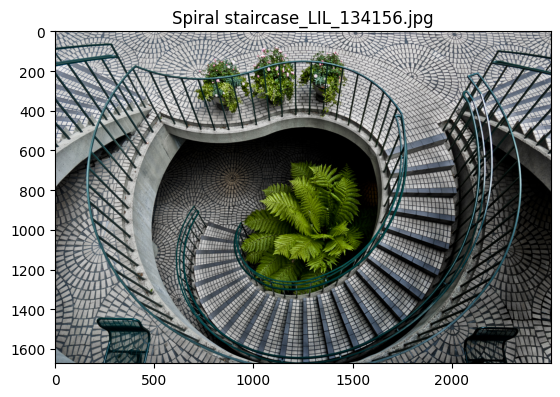

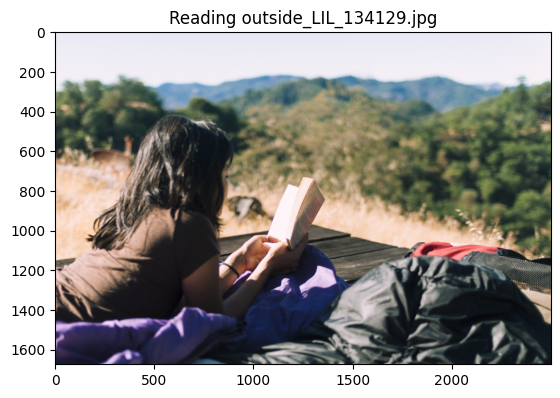

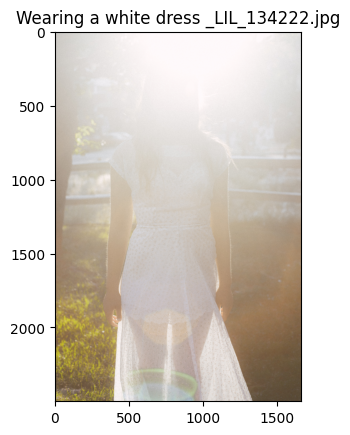

In [29]:
# Compare test image with all images in the dataset and return the most similar image and plot it
test_img = mpimg.imread("D:/Vector Databases/vector-databases-certification/03 Machine Learning Vectors/TestImages/Alone in office building _LIL_134159.jpg")
imgplot = plt.imshow(test_img)
plt.title("Test Image")
plt.show()

for img in query_image['data']['Get']['TextImageSearch']:
    img_name = img['text']
    img_path = f"{image_folder}/{img_name}"
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.title(img_name)
    plt.show()